<font size=5>
  Manuel Weitzman 201473501-4 --- Andrés Huerta 201473544-8
  </font>

In [0]:
#csv desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
from sklearn.metrics import f1_score
from keras.layers import GRU
from keras.layers import Bidirectional

#display(HTML("<style>.container { width:95% !important; }</style>"))
#display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
#display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

Using TensorFlow backend.


In [0]:
df_ner = pd.read_csv("drive/My Drive/Colab Notebooks/entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


> a) En esta primera instancia trabajaremos con la tarea de realizar un NER tag (Named Entity Recognition) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo many to many, es decir, la entrada es una secuencia y la salida es una secuencia, sin shift, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar lemma en vez de la misma palabra?

In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

Se prefiere la ultilización de lemma debido a que una palabra se puede escribir de multiples formas de acuerdo al contexto en el cual se utilice, lemmatizer corresponde a la normalización de las palabras a su raiz, por lo que existiria una sola forma (o eso se espera) de escribir una palabra.

In [0]:
dataset.head(13)

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


El dataset se compone de 5 atributos seleccionados, el primero "lemma" corresponde a la raíz de la palabra que se esta utilizando, "word" es la palabra explicita que se utiliza en la frase, "pos" indica el tag del token actual, "tag" anotación del token actual, "prev-iob" indica el token de la palabra anterior.

In [0]:
dataset.tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

Existen un total de 17 labels que determinan que tipo de frase se esta utilizando.

> Luego de esto cree una estructura que contendrá todas las sentencias u oraciones (lista de *lemmas*) y otra estructura que contendrá las etiquetas (lista de *tags*). **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**

In [0]:
n_used = 750000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
sentence, labels_sentence = list(), list()
lemmas,labels = set(), set()  #uniques
#Se recorre el dataset hasta la ultima palabra indicada por n_used
for fila in dataset.values[:n_used]:
    #Se determina si la palabra utilizada es el inicio de una horación
    if fila[-1]=="__START1__": 
        #Se guardan en el dataset la oracion con sus tags
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]

In [0]:
print("Total de sentencias:",len(dataX_raw))
print("Total de etiquetas:",len(labels))
print("Total de palabras:",len(lemmas))

Total de sentencias: 34308
Total de etiquetas: 17
Total de palabras: 15959


El dataset posee un total de 34308 oraciones etiquetadas con 17 posibles tags, ademas se cuenta con un total de 15959 palabras posibles a utilizar en una oración.

Debido a la naturaleza del lenguaje las dimensiones de cada ejemplo no son iguales para cada caso, dependiendo del contexto una oración puede estar constituida por cantidades distintas de palabras.

Para poder entrenar redes en keras, es necesario dar un formato similar a cada input por lo que sera necesario dar un formato estandar para el desarrollo.

> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. ¿Se observa una ley Zipf? Realice un gráfico de la cantidad de datos por clase. Comente.

In [0]:
freqs_sentence = dict()
freqs_words = dict()
for sentence in dataX_raw:
    if len(sentence) not in freqs_sentence.keys():
        freqs_sentence[len(sentence)] = 1
    else:
        freqs_sentence[len(sentence)] += 1
    for word in sentence:
        if word not in freqs_words.keys():
            freqs_words[word] = 1
        else:
            freqs_words[word] += 1

freqs_tags = dict()
for sentence in dataY_raw:
    for tag in sentence:
        if tag != 'O':
          if tag not in freqs_tags.keys():
            freqs_tags[tag] = 1
          else:
            freqs_tags[tag] += 1

print("Máxima cantidad de palabras en una frase:",max(freqs_sentence.keys()))
print("Mínima cantidad de palabras en una frase:",min(freqs_sentence.keys()))

Máxima cantidad de palabras en una frase: 81
Mínima cantidad de palabras en una frase: 1


La máxima cantidad de palabras contenidas dentro de una oración es de 81 palabras, mientras que la mínima cantidad de palabras definidas para desarrollar una frase en el ejercicio son solo 1.

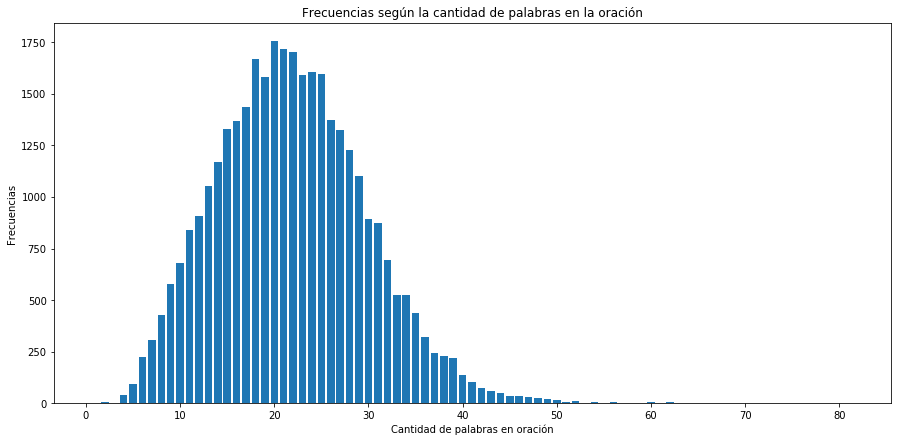

In [0]:
plt.figure(figsize=(15,7))

plt.bar(freqs_sentence.keys(), freqs_sentence.values())
plt.xlabel('Cantidad de palabras en oración')
plt.ylabel('Frecuencias')
plt.title('Frecuencias según la cantidad de palabras en la oración')

plt.show()

La mayoria de las frases utilizadas contienen entre 15 a 25 palabras, se puede ver una aparente distribución normal en las frecuencias de las palabras.

In [0]:
keys_high = sorted(freqs_words, key=freqs_words.get, reverse=True)[:75]

keys_high_dict = dict()
  
for key in keys_high:
  keys_high_dict[key] = freqs_words[key]

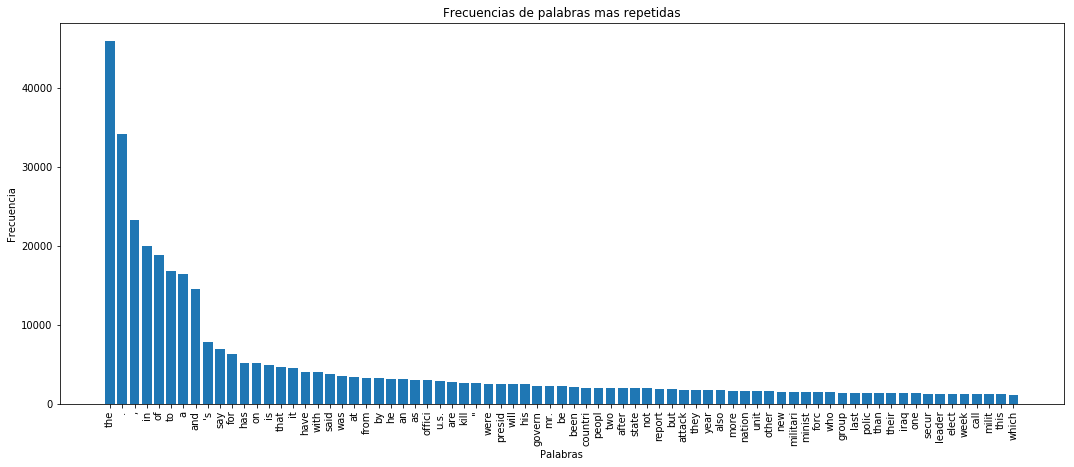

In [0]:
plt.figure(figsize=(18,7))

plt.bar(keys_high_dict.keys(), keys_high_dict.values())
plt.xticks(rotation='vertical')
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Frecuencias de palabras mas repetidas")
plt.show()

Analizando las palabras mas repetidas se puede notar que existen "palabras" que corresponden a puntuaciones por lo que se eliminan de la observación.

Se puede notar que las 25 palabras mas repetidas, son en su mayoría conectores que en la mayoría de los casos no otorgan un gran valor al contexto de la frase, quizas seria recomendable remover aquellas palabras que se repiten una gran cantidad de veces.

In [0]:
all_vocab = dict()

for word in dataset.values[:]:
    if word[0].isalpha():
        if word[0] not in all_vocab.keys():
            all_vocab[word[0]] = 1
        else:
            all_vocab[word[0]] += 1
            
vocab_list = [(all_vocab[key], key) for key in all_vocab.keys()]
vocab_list.sort(reverse=True)

x_ticks = list()
y_ticks = list()

for i in range(len(vocab_list)):
    x_ticks.append(np.log(i + 1))
    y_ticks.append(np.log(vocab_list[i][0]))


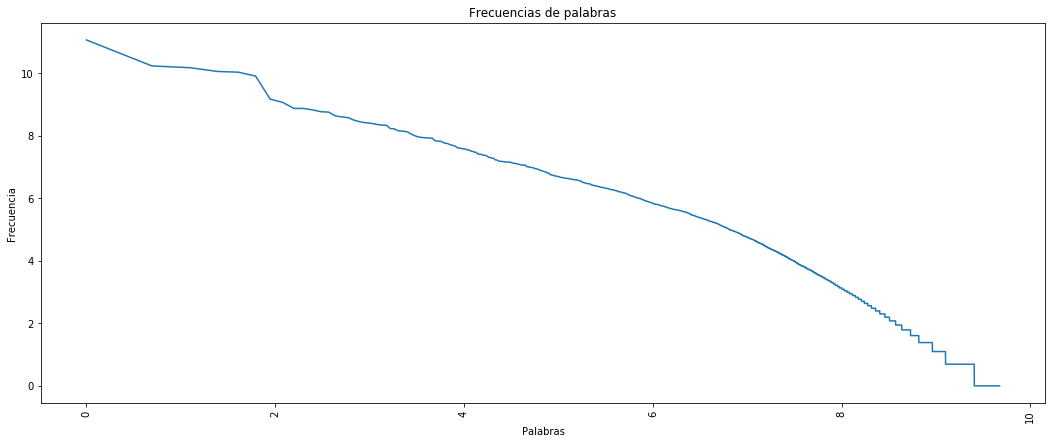

In [0]:
plt.figure(figsize=(18, 7))

plt.plot(x_ticks, y_ticks)
plt.xticks(rotation='vertical')
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Frecuencias de palabras")

plt.show()

La ley de zipf corresponde a que en un vocabulario la frecuencia en la aparición de las palabras sigue la distribución:

$$P_{n} \sim \frac{1}{n^{a}}$$

Lo que quiere decir que el segundo elemento correspondera aproximadamente a 1/2 del primero, el tercero a 1/3 y así sucesivamente, en este caso se puede notar a simple vista que existe esa relación entre el primero y el segundo, el tercero no es tan notorio, pero se debe recordar que se esta trabajando con probabilidades, se puede notar que a la larga si existe una tendencia a lo especificado, por lo que se podría considerar que si se cumple la ley de zipf.

In [0]:
quantity = 0

for key in freqs_words.keys():
    if freqs_words[key] <= 50:
      quantity += 1
      
print("Cantidad de palabras con igual o menos de 50 repeticiones:",quantity)

Cantidad de palabras con igual o menos de 50 repeticiones: 14351


Existen 14351 palabras que se repiten menos de 50 veces, por motivos de espacio se decidio no realizar un gráfico de estos valores, pero se debe tener claro que del universo de 15959 lemmas una gran cantidad de estas palabras no aparecen muchas veces en el dataset.

In [0]:
tags_tuples = [(freqs_tags[key], key) for key in freqs_tags.keys()]
tags_tuples.sort(reverse=True)

x_ticks = list()
y_ticks = list()

for i in range(len(tags_tuples)):
    y_ticks.append(tags_tuples[i][0])
    x_ticks.append(tags_tuples[i][1])

Se procede a gráficar la frecuencia de los tags o lo que vendría a hacer nuestro valor a predecir.

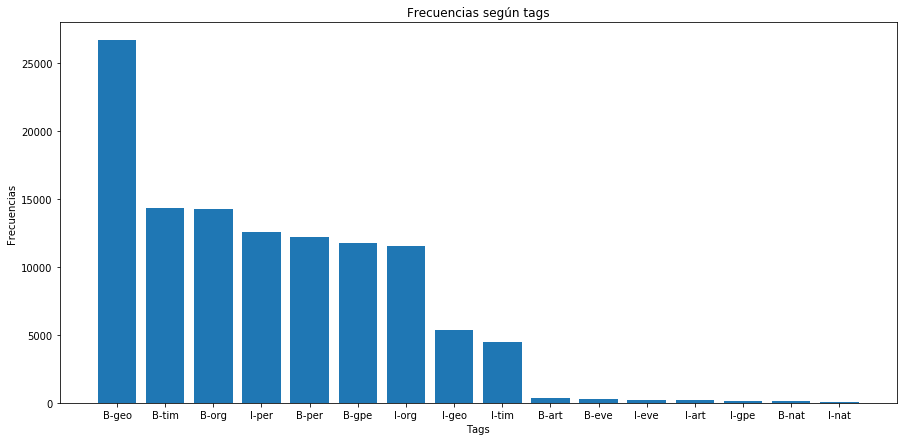

In [0]:
plt.figure(figsize=(15,7))

plt.bar(x_ticks, y_ticks)
plt.xlabel('Tags')
plt.ylabel('Frecuencias')
plt.title('Frecuencias según tags')

plt.show()

Se puede notar un claro desbalance de clases en los tags, sera necesario tomar medidas para evitar que la red clasifique los textos basandose unicamente en la mayor frecuencia, ademas sera necesario implementar algo para evitar que el desbalance afecte mucho en la separanción de los conjuntos de entrenamiento y testing.

> c) Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**

In [0]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs
n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [0]:
print("Total de etiquetas:",len(lab2idx))
print("Total de palabras:",len(lemma2idx))

Total de etiquetas: 17
Total de palabras: 15959


Existen un total de 17 etiquetas posibles para cada sentencia y un total de 15959 distintos lemmas

In [0]:
for i in labels:
  print(i)

I-geo
B-gpe
O
I-gpe
B-nat
I-art
B-geo
B-org
I-tim
B-per
I-per
I-nat
I-org
B-tim
B-art
B-eve
I-eve


El tag para cada lemma, esta indicando respecto a que hace referencia la frase que se esta utilizando en la oración, por ejemplo B-geo hace referencia a un lugar geografico, B-per indica que en la frase u oración se esta haciendo referencia a una persona y B-tim hace referencia a un punto en el tiempo y asi sucesivamente, el tag O corresponde a nada de momento en la frase, en otras palabras quiere decir que la frase aun no ha terminado.

In [0]:
max_input_lenght = len(max(dataX, key=len))

El largo máximo corresponde a 81 palabras dentro de una sentencia.

> d) Debido a la distinta extensión de textos se deberá **realizar *padding* para estandarizar el largo**,
considere algun carácter especial **no presente en el vocabulario** para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*N, N*]. Decida, respecto al cómo funciona una red recurrente y su *memoria*, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente

In [0]:
lemma2idx["ANVORGESA"] = n_lemmas #add fullfill lemma and tag to the dictionary
lab2idx["ANVORGESA"] = n_labels
n_labels +=1
n_lemmas +=1
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=max_input_lenght,padding='post',value=lemma2idx["ANVORGESA"])
y = sequence.pad_sequences(dataY, maxlen=max_input_lenght,padding='post',value=lab2idx["ANVORGESA"])
del dataY[:],dataX[:]

Se decide utilizar realizar el padding posterior a la sentencia utilizada, esto se utiliza para que el padding no afecte en el final de la sentencia hasta que se haya leido toda la frase, debido al funcionamiento que tienen las redes recurrentes la desición se vera mas afectada por lo que ha leido hasta hace poco, si se realiza el padding antes de la frase puede ser que la red considere la cantidad de veces que se repite dicho ENDPAD para tomar una desición.

**Despues de haber trabajado:**

Aparentemente para problemas de este estilo con redes recurrentes es mas eficiente realizar pre-padding, aún así comparando resultados con otros experimentadores en este mismo ejercicio se obtuvo que los resultados eran similares, posiblemente dado que existe una mayor cantidad de neuronas que máximo de palabras en el input es posible que existan algunas que logran aprender lo necesario para determinar el contexto de la sentencia

> e) Para poder generar una representación adecuada sobre los datos de entrada que permita realizar operaciones lineales, deberá generar una representación a un vector denso. Para ésto se utilizará la arquitectura de autoencoder **Word2Vec** sobre textos *raws* de largo variable, en donde el *encoder* codifica una palabra categórica (*target*) a un vector denso de dimensionalidad $d$ mientras que el *decoder* genera palabras en el contexto (*context*) de la palabra *target* (en una vecindad alrededor). La idea detrás es que palabras similares sean proyectadas a una región cercana en el espacio de *embedding* ¿Cuál es la importancia del parámetro min_count? ¿Cuántos *lemmas* ve Word2Vec?

In [0]:
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 5
model = Word2Vec(dataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}
print("Cantidad de lemmas:",len(embeddings_index.keys()))

Cantidad de lemmas: 6500


**Un Word2Vec funciona como una red de 2 capas dentro del modelo desarrollado,  se enfoca principalmente en encontrar relaciones entre palabras o que tan cercanas son unas de otras. Este al final lo que intenta realizar es generar un vector de contexto para que nuestra segunda capa de nuestra red pueda interpretar de mejor manera la sentencia trabajada, por lo que funciona particularmente bien cuando se esta intentando buscar el contexto de una frase. Esta capa o parte de la red funciona obteniendo relaciones entre palabras, por lo que a una mayor cantidad de ejemplos mejor sera la relación determinada.**

El atributo min_count determina la cantidad minima de apariciones que debe tener una palabra para ser considerada dentro de la representación de modo que se pueda asociar con otra, si se ignora dicho parámetro entonces la función utilizara palabras que aparecen una unica vez, esto genera que el tamaño de la matriz a generar sea muy grande y las relaciones generadas podrían ser insignificantes utilizando memoria que no entrega ningun tipo de información.

con el atributo min_count definido el Word2Vec reconoce 6500 palabras dentro del vocabulario, esto significa que cuando aparesca una palabra que no corresponda al vocabulario probablemente sera ignorada por la red.

Genere una matriz de *embeddings* que se utilizarán como capa neuronal.

In [0]:
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector

En este punto se genera el vocabulario para utilizar en la red neuronal, el if dentro del codigo anterior determina si la palabra observada esta dentro de las palabras consideradas para el vocabulario, de ser así se agregan al vocabulario.

Luego, para poder realizar una clasificación sobre los datos en la salida será necesario representarlos *one hot vectors*, esto resultará en un arreglo tridimensional.

In [0]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

> f) Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [0]:
print("X train shape:",X_train.shape,"test:",X_test.shape)
print("y train shape:",y_train.shape,"test:",y_test.shape)

X train shape: (24015, 81) test: (10293, 81)
y train shape: (24015, 81, 18) test: (10293, 81, 18)


El conjunto de entrenamiento cuenta con 24015 ejemplos, mientras que el de testing cuenta con 10293.

Para las dimensiones los atributos con los que cuenta cada ejemplo corresponde al texto que lleva, se define un tamaño 81 correspondiente a la máxima cantidad de palabras posibles para generar una sentencia (para este caso), el conjunto "y" cuenta un tag distinto para cada palabra que aparece en las 81 posibles posiciones de la palabra, este valor puede ser 1 de los 18 posibles tags.

> g) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red es una por cada instante de tiempo que se necesita entregar un *output*. La primera capa de la red a construir debe tener los vectores de *embedding* encontrados por **Word2Vec**. 

In [0]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')

W0730 21:13:07.934280 140436590393216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 21:13:07.955459 140436590393216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 21:13:07.957911 140436590393216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 21:13:07.968577 140436590393216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0730 21:13:07.971258 1404365903

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 81, 18)            1818      
Total params: 565,738
Trainable params: 55,018
Non-trainable params: 510,720
_________________________________________________________________


>  **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

Siendo el input unicamente la oracion con 81 palabras (incluidas el padding) al ingresar a la red las dimensiones de esta se ven aumentados a la salida de la primera capa, esto se debe a la codificación de cada palabra a un vector de 32 atributos por la capa de embedding.

Para la siguiente capa entrega el input a cada neurona (100 en la capa), donde cada neurona intentara aprender las caracteristicas importantes del problema.

La capa TimeDistributed permite a la red generar un output por cada palabra que le llega a la capa, esta capa es la que nos permite generar una red many to many, de no estar se entregaria tan solo una respuesta.

La cantidad de parametros que posee la red neuronal corresponden a 565738, pero de estos solo 55018 son entrenables, el motivo por el cual son pocos es que en lugar de generar una capa por cada timestamp de la sentencia, lo que generaria alrededor de 81 capas se utiliza solo una capa que leera distintos timestamps de la frase con pesos compartidos.

> **Entrene y luego evalúe su desempeño sobre ambos conjuntos.**

In [0]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

W0730 21:13:08.972889 140436590393216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def plot_losses(hist): 
  plt.figure(figsize=(15, 7))
  
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  
  plt.legend(["Train Loss", "Val Loss"], loc="upper right")
  
  plt.title("Traning & Test Losses")
  
  plt.show()
  
  print("Final Train Loss:",hist.history['loss'][-1])
  print("Min val_loss:",min(hist.history['val_loss']))

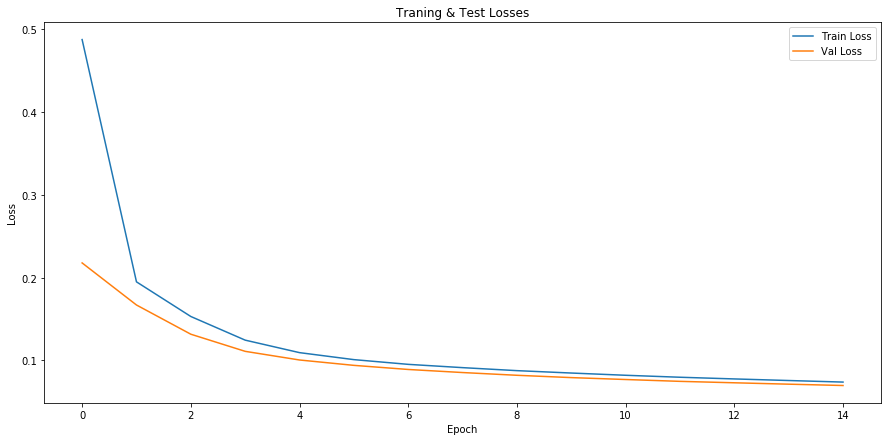

Final Train Loss: 0.07383973335111585
Min val_loss: 0.06970516085497297


In [0]:
plot_losses(history)

Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases como identificó en el punto b). Tenga presente en este punto el **no evaluar** la clase/símbolo que añadió para realizar *padding* a los *tag*.  
*Hint: podría "truncar" la salida predicha hasta el largo real de esa sentencia*.

In [0]:
def predict_and_truncate(model, X_test, y_test):
  dataY_pred = model.predict_classes(X_test,verbose=0)

  dataY_pred_truncated = list()

  y_test_transformed = list()
  for example in y_test:
      y_test_transformed.append([np.argmax(y, axis=None, out=None) for y in example])
  y_test_t_t = list()

  sentence_index = 0 #Index allows us to check the same row in the predicted and true dataset
  for sentence in X_test:
    word_index = 0
    for word in sentence:
      if word == lemma2idx["ANVORGESA"]:
        dataY_pred_truncated.append(dataY_pred[sentence_index][:word_index])
        y_test_t_t.append(y_test_transformed[sentence_index][:word_index])
        break
      word_index += 1
    sentence_index += 1
    
  return dataY_pred_truncated, y_test_t_t

In [0]:
y_pred, y_test_t = predict_and_truncate(model, X_test, y_test)

f1_score_bydata = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]
print("\nF1 score on test: ", np.mean(f1_score_bydata) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score on test:  0.912730488765349


Para ignorar las predicciones realizadas en el END (ANVORGESA) se trunca todo lo que vaya posterior a la lectura de dicho termino, luego se procede a obtener una media del f1_score por cada clase donde se toma en cuenta el peso de cada clase.

El valor del f1_score obtenido en primera instancia corresponde a 0.91

> h) Varíe con seguir entrenando la capa de embedding seteada al definir la arquitectura, ésto es cambiar a *trainable=True*, compare el desempeño y el número de parámetros (entrenables) con lo anterior. Comente

In [0]:
modelt = Sequential()
modelt.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
modelt.add(LSTM(units=100,return_sequences=True))
modelt.add(Dropout(0.2))
modelt.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelt.compile(loss='categorical_crossentropy', optimizer='adam')

La variable trainable dentro del Embedding permite al modelo tunear pesos a distintas palabras basadas en su influencia sobre las frase basados en los datos entregados en el conjunto de entrenamiento permitiendole a la red determinar que apariciones de palabras resultan tener una mayor importancia que otras.

In [0]:
print("\nModified")
print(modelt.summary())


Modified
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 81, 18)            1818      
Total params: 565,738
Trainable params: 565,738
Non-trainable params: 0
_________________________________________________________________
None


Se puede notar que la cantidad de parámetros entrenables aumento hasta la totalidad de los parámetros presentes en la red, esto implica que la mayoría de los pesos que existen en la red se encuentran en la primera parte del modelo.

In [0]:
historyt = modelt.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

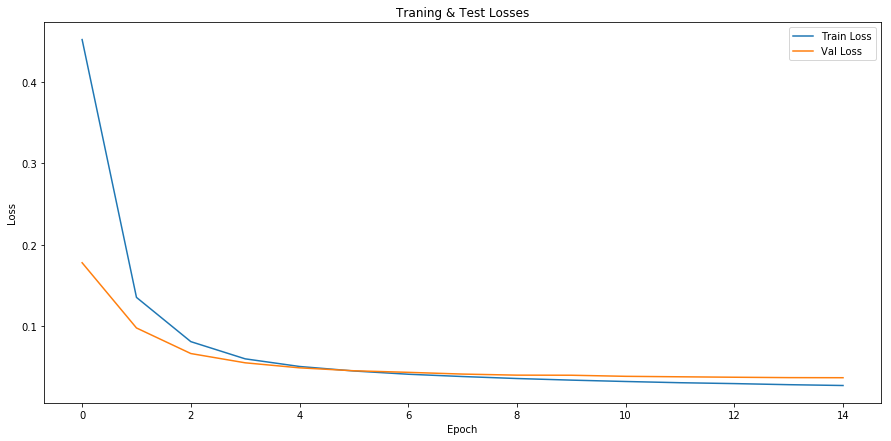

Final Train Loss: 0.027581555563619107
Min val_loss: 0.0371317296596272


In [0]:
plot_losses(historyt)

In [0]:
y_pred, y_test_t = predict_and_truncate(modelt, X_test, y_test)

f1_score_bydata2 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score new model on test: ", np.mean(f1_score_bydata2) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.912730488765349

F1 score new model on test:  0.9583396231655597


El f1_score del modelo entrenado con un embedding entrenable aumenta con respecto al modelo sin, en alrededor de 0.04 unidades.

> i) Experimente con cambiar la *gate* de recurrencia a una con menos parámetros pero que mantiene la capacidad de memoria de la LSTM, ésta es la compuerta GRU. Comente sobre los resultados esperados y observados.

In [0]:
modelg = Sequential()
modelg.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
modelg.add(GRU(units=100,return_sequences=True))
modelg.add(Dropout(0.2))
modelg.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelg.compile(loss='categorical_crossentropy', optimizer='adam')

Una compuerta GRU a diferencia de una LSTM se caracteriza por utilizar solo 2 compuertas en lugar de , una de reset y otra de update lo que implica una menor cantidad de parámetros a entrenar, esto lleva a pensar que esta compuerta resulta ser mucho mas eficiente en la velocidad de entrenamiento que la primera, de acuerdo a la literatura posee un rendimiento que va a la par del LSTM.

La compuerta Reset determina como combinar los elementos pasados que ha recibido la red mientras que la compuerta Update determina que tanta información retener de los inputs anteriores.

In [0]:
print("\nGRU")
print(modelg.summary())


GRU
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
gru_1 (GRU)                  (None, 81, 100)           39900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 81, 18)            1818      
Total params: 552,438
Trainable params: 41,718
Non-trainable params: 510,720
_________________________________________________________________
None


La cantidad de parámetros entrenables disminuye en alrededor de 15000 unidades.

In [0]:
historyg = modelg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

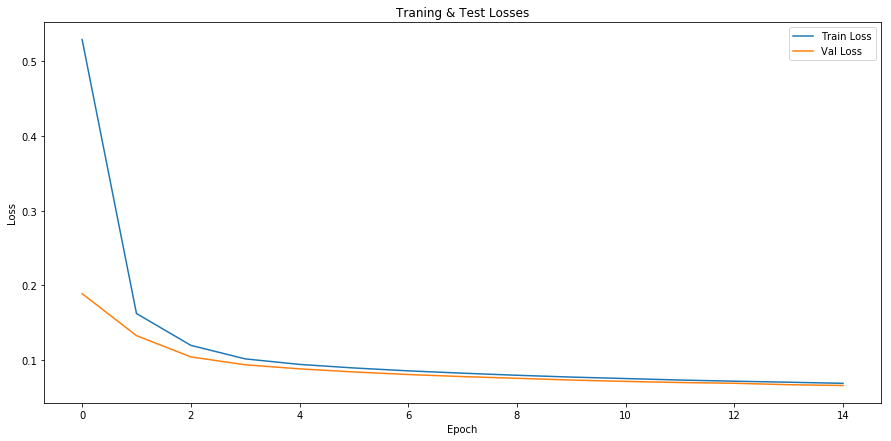

Final Train Loss: 0.06881296578643473
Min val_loss: 0.06589109818221736


In [0]:
plot_losses(historyg)

In [0]:
y_pred, y_test_t = predict_and_truncate(modelg, X_test, y_test)

f1_score_bydata3 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score trainable model on test: ", np.mean(f1_score_bydata2) )
print("\nF1 score gru model on test: ", np.mean(f1_score_bydata3) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.912730488765349

F1 score trainable model on test:  0.9583396231655597

F1 score gru model on test:  0.91869549818392


Si bien, el modelo entrenado en este caso no supera el score obtenido por el modelo con embedding entrenable si supera el score del modelo basico entrenado con compuertas LSTM, por lo menos en este caso la compuerta GRU obtiene un mejor rendimiento que la clasica.

> j) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas*. 



> **Comente cuál debiera ser la forma correcta de usar el parámetro merge_mode (concatenar, multiplicar, sumar o promediar) para este caso.** 

Al intentar determinar el contexto de una frase con respecto a las palabras utilizadas se determina que es mas conveniente utilizar la concatenación para realizar este ejercicio, esto para evitar la posible perdida de información a la que se exponen los otros tipos de operación merge.

> **Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.**

In [0]:
modelb = Sequential()
modelb.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
gate_layer = LSTM(units=100,return_sequences=True)
modelb.add(Bidirectional(gate_layer, merge_mode='concat'))
modelb.add(Dropout(0.2))
modelb.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelb.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
modelb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 81, 200)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 81, 18)            3618      
Total params: 620,738
Trainable params: 110,018
Non-trainable params: 510,720
_________________________________________________________________


Al agregar la capa bidireccional la cantidad de parámetros entrenables se duplica, se asume que al elegir la operación de concatenación se duplican las cantidad celdas existentes en la capa, esto se debe a que la primera mitad o la original estaran encargadas de trabajar con las secuencias en el orden original mientras que las restantes se enfocaran en el aprendizaje de la secuencia al reves. Esto lleva a pensar que la concatenación de secuencias puede significar un mayor costo operacional, pero los datos analizables seran más ricos en información.

In [0]:
historyb = modelb.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

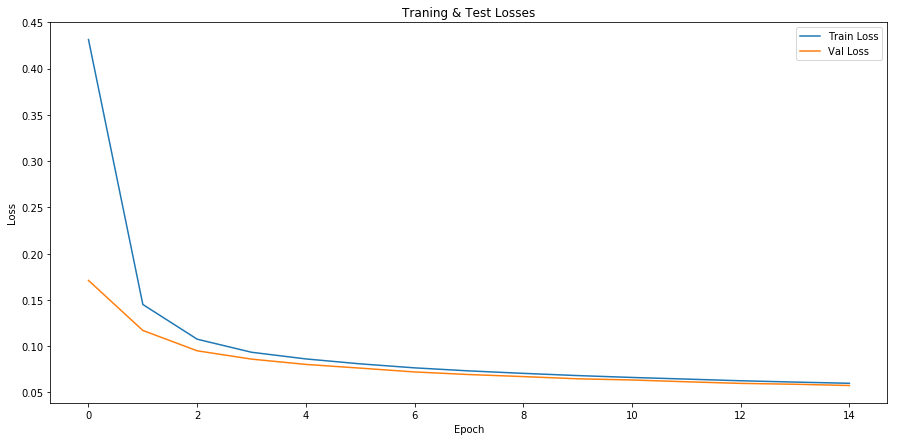

Final Train Loss: 0.059844190091695136
Min val_loss: 0.05744987724908619


In [0]:
plot_losses(historyb)

In [0]:
y_pred, y_test_t = predict_and_truncate(modelb, X_test, y_test)

f1_score_bydata4 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score trainable model on test: ", np.mean(f1_score_bydata2) )
print("\nF1 score gru model on test: ", np.mean(f1_score_bydata3) )
print("\nF1 score bidirectional model on test: ", np.mean(f1_score_bydata4) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.912730488765349

F1 score trainable model on test:  0.9583396231655597

F1 score gru model on test:  0.91869549818392

F1 score bidirectional model on test:  0.9299284220782721


El aplicar la bidireccionalidad de la secuencia si mejora en parte el desempeño de la red, pero solo por 0.01, tambien logra superar el desempeño del modelo con compuertas gru, pero hasta el momento la capacidad de realizar un embedding entrenable ha resultado ser lo mas efectivo a cambio de un mayor costo de ejecución.

> k) En base a lo experimentado, **mejore el desempeño de las redes encontradas**, ya sea utilizando y/o combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (en https://keras.io/layers/recurrent/), cambiar los vectores de *embedding* por unos entrenados en otros dataset más grandes (https://nlp.stanford.edu/projects/glove/), entre otros.

Para el mejoramiento del desempeño del modelo se decide por utilizar una matriz de embedding entrenada por un dataset mas grande, particularmente para generar un vector de 200 dimensiones (se comparo con vectores de 50, 100 y 200), ademas se permitio al embedding ser entrenado con el conjunto de entrenamiento para poder ajustar los vectores al contexto que se esta trabajando actualmente.

In [0]:
embeddings_index2 = dict()
EMBEDDING_DIM2 = 200

f = open('drive/My Drive/glove.6B.'+str(EMBEDDING_DIM2)+'d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index2))

Found 400000 word vectors.


In [0]:
embedding_matrix2 = np.zeros((n_lemmas, EMBEDDING_DIM2))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index2.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix2[i] = embedding_vector

Se utilizo una compuerta GRU debido a los mejores resultados obtenidos al comparar con LSTM, ademas se aumento la cantidad de celdas de la capa en 50 unidades.

Ademas, se utilizo la información bidireccionalmente concatenado las secuencias.

In [0]:
modelf = Sequential()
modelf.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM2, input_length=max_input_lenght,
                     trainable=True, weights = [embedding_matrix2]))
gate_layer = GRU(units=150,return_sequences=True)
modelf.add(Bidirectional(gate_layer, merge_mode='concat'))
modelf.add(Dropout(0.2))
modelf.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelf.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
historyf = modelf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

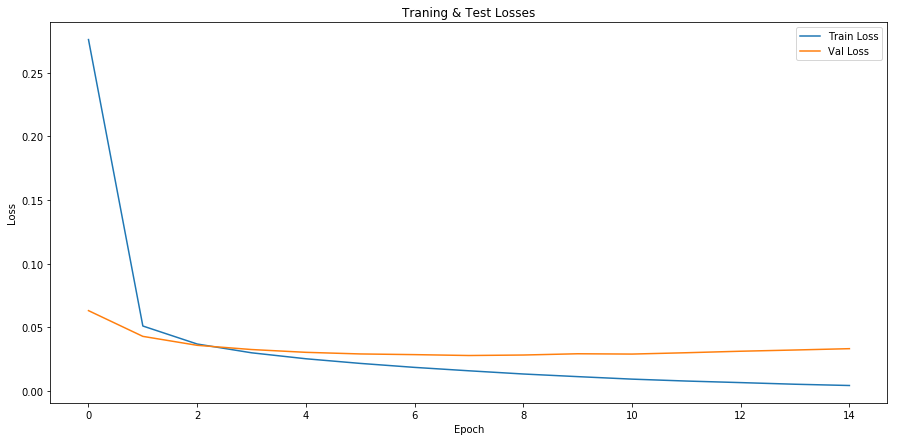

Final Train Loss: 0.004103441434898229
Min val_loss: 0.027699927657438728


In [0]:
plot_losses(historyf)

In [0]:
y_pred, y_test_t = predict_and_truncate(modelf, X_test, y_test)

f1_score_bydata5 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score trainable model on test: ", np.mean(f1_score_bydata2) )
print("\nF1 score gru model on test: ", np.mean(f1_score_bydata3) )
print("\nF1 score bidirectional model on test: ", np.mean(f1_score_bydata4) )
print("\nF1 score bidirectional and gru model on test: ", np.mean(f1_score_bydata5) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.912730488765349

F1 score trainable model on test:  0.9583396231655597

F1 score gru model on test:  0.91869549818392

F1 score bidirectional model on test:  0.9299284220782721

F1 score bidirectional and gru model on test:  0.9762138511822079


Se puede ver una mejora significativa en comparación a los otros modelos implementados, el f1_score supera al mejor modelo encontrado hasta ahora (embedding entrenable) por lo que se logra alcanzar el objetivo de la pregunta. Dentro de los cambios mas significativos se destaca la utilización de un embedding entrenado con un dataset mas extenso.

> l) Utilice la red con mejor desempeño encontrada, idealmente la encontrada en (j), y **muestre las predicciones** del *NER tager*, sobre algún ejemplo de pruebas, comente. 

In [0]:
inv_lemma = {v: k for k, v in lemma2idx.items()}
inv_labels = {v: k for k, v in lab2idx.items()}

In [0]:
idx = np.random.choice(np.arange(y_test.shape[0]), size=7, replace=False)

In [0]:
for i in idx:
  p = modelf.predict([[X_test[i]]])  #(np.array([X_test[0]]))
  p = np.argmax(p, axis=-1)
  labels_list = list(labels)
  lemmas_list = list(lemmas)
  print("\n{:15}: {:7} , {}".format("Lemma", "Pred", "True"))
  for word,pred,true in zip(X_test[i],p[0],y_test[i]):
      if not word == 15959:
          print("{:15}: {:7} | {}".format(inv_lemma[word],inv_labels[pred],inv_labels[np.argmax(true, axis=None, out=None)]))


Lemma          : Pred    , True
the            : O       | O
exchang        : O       | O
's             : O       | O
secur          : O       | O
chief          : O       | O
moham          : B-per   | B-per
aslam          : I-per   | I-per
said           : O       | O
investor       : O       | O
began          : O       | O
smash          : O       | O
window         : O       | O
after          : O       | O
the            : O       | O
administr      : O       | O
declin         : O       | O
to             : O       | O
suspend        : O       | O
trade          : O       | O
.              : O       | O

Lemma          : Pred    , True
today          : B-tim   | B-tim
's             : O       | O
visit          : O       | O
come           : O       | O
ahead          : O       | O
of             : O       | O
a              : O       | O
summit         : O       | O
in             : O       | O
brazil         : B-geo   | B-geo
next           : O       | O
week           : O 

Se puede notar que en general las frases estan bien catalogadas. Los errores comunes detectados dentro de los casos observados son etiquetas a palabras que no son suficientes para determinar el contexto o que por lo menos en las etiquetas reales no son suficientes, pero en aquellas palabras donde se supone ya es posible determinarlo no se logra detectar ningun error.